In [1]:
'''
Copyright (c) Microsoft Corporation. All rights reserved.
Licensed under the MIT License.
'''
### Run the following command to install required packages:
#! pip install -r requirements.txt

In [2]:
import cv2
import glob
import numpy as np
import os
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import image
%matplotlib inline
from pylab import *
from keras.models import Sequential
from keras.optimizers import Adam, SGD, Adamax
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model
from scipy import spatial

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform,he_uniform

from sklearn.manifold import TSNE
import seaborn as sns

import matplotlib.pyplot as plt

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.utils import plot_model,normalize

from sklearn.metrics import roc_curve,roc_auc_score

Using TensorFlow backend.


In [3]:
current_dir = "./blue_whales/"

data_dir = current_dir + "data/"
labeled_data_dir = data_dir + 'labeled_data/'
spectrogram_dir = data_dir + "extracted_spectrogram/"

In [ ]:
label_list = glob.glob(labeled_data_dir + '*.csv')
label_list

In [5]:
ANT_calls = pd.read_csv(labeled_data_dir + 'ANT_calls.csv')
AUS_calls = pd.read_csv(labeled_data_dir + 'AUS_calls.csv')
MAD_calls = pd.read_csv(labeled_data_dir + 'MAD_calls.csv')
SRI_calls = pd.read_csv(labeled_data_dir + 'SRI_calls.csv')

all_calls = [ANT_calls, AUS_calls, MAD_calls, SRI_calls]
all_calls = pd.concat(all_calls).reset_index(drop=True)
all_calls.head()

,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Site,Audio_filename,Species
0,36.429460,49.757312,17.2,26.7,SWAMS2015,1023.wav,ANT
1,99.896669,111.834007,17.0,26.3,SWAMS2015,1023.wav,ANT
2,163.353043,174.033819,17.9,27.1,SWAMS2015,1023.wav,ANT
3,228.065980,238.746755,18.5,27.6,SWAMS2015,1023.wav,ANT
4,292.778916,309.742501,17.4,26.9,SWAMS2015,1023.wav,ANT


In [7]:
positive_spectrogram_filenames = glob.glob(spectrogram_dir + '*_Positive_*')
len(positive_spectrogram_filenames)

6279

In [8]:
spectrogram_with_bounding_box_axis = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

spectrogram_length_seconds = 240
spectrogram_frequency = 120

for i in range(len(positive_spectrogram_filenames)):
    img_name = positive_spectrogram_filenames[i].split('/')[-1]
    species_name = img_name.split('_')[0]
    audio_filename = img_name.split('_')[2] + '.wav'
    start_second = int(img_name.split('_')[3]) 
    end_second = int(img_name.split('_')[4].split('.')[0])
    tmp_df = all_calls[(all_calls['Species'] == species_name) & 
                       (all_calls['Audio_filename'] == audio_filename) &
                       (all_calls['Begin Time (s)'] >= start_second) & 
                       (all_calls['End Time (s)'] <= end_second)
                      ]
    for index, row in tmp_df.iterrows():
        spectrogram_with_bounding_box_axis = spectrogram_with_bounding_box_axis.append({'FileName': positive_spectrogram_filenames[i], 
                                                                                        'XMin': (row['Begin Time (s)'] - start_second) / spectrogram_length_seconds, 
                                                                                        'XMax': (row['End Time (s)'] - start_second) / spectrogram_length_seconds, 
                                                                                        'YMin': 1 - row['High Freq (Hz)'] / spectrogram_frequency, 
                                                                                        'YMax': 1 - row['Low Freq (Hz)'] / spectrogram_frequency, 
                                                                                        'ClassName': species_name},
                                                                                        ignore_index=True)
            

In [9]:
print('shape of bounding box data: ', spectrogram_with_bounding_box_axis.shape)
spectrogram_with_bounding_box_axis.head(20)

shape of bounding box data:  (16258, 6)


,FileName,XMin,XMax,YMin,YMax,ClassName
0,/mnt/blue-whales/Data/Extracted_Spectrogram/AN...,0.042812,0.108202,0.760000,0.796667,ANT
1,/mnt/blue-whales/Data/Extracted_Spectrogram/AN...,0.371628,0.405257,0.760000,0.796667,ANT
2,/mnt/blue-whales/Data/Extracted_Spectrogram/AN...,0.054962,0.088590,0.760000,0.796667,ANT
3,/mnt/blue-whales/Data/Extracted_Spectrogram/AN...,0.004794,0.057828,0.791667,0.815833,ANT
4,/mnt/blue-whales/Data/Extracted_Spectrogram/AN...,0.098821,0.132316,0.773333,0.810833,ANT
5,/mnt/blue-whales/Data/Extracted_Spectrogram/AN...,0.000093,0.076693,0.792500,0.825000,ANT
6,/mnt/blue-whales/Data/Extracted_Spectrogram/AN...,0.450322,0.520103,0.791667,0.824167,ANT
7,/mnt/blue-whales/Data/Extracted_Spectrogram/AN...,0.113094,0.161669,0.772500,0.801667,ANT
8,/mnt/blue-whales/Data/Extracted_Spectrogram/AN...,0.449383,0.512904,0.779167,0.811667,ANT
9,/mnt/blue-whales/Data/Extracted_Spectrogram/AN...,0.573826,0.598947,0.767500,0.795000,ANT


In [10]:
spectrogram_positive_call_counts = spectrogram_with_bounding_box_axis[['FileName', 'ClassName']].groupby(['FileName', 'ClassName']).size().reset_index(name='CallCounts')
print('shape of spectrogram_positive_call_counts data: ', spectrogram_positive_call_counts.shape)
spectrogram_positive_call_counts.head()

shape of spectrogram_positive_call_counts data:  (6274, 3)


,FileName,ClassName,CallCounts
0,/mnt/blue-whales/Data/Extracted_Spectrogram/AN...,ANT,2
1,/mnt/blue-whales/Data/Extracted_Spectrogram/AN...,ANT,1
2,/mnt/blue-whales/Data/Extracted_Spectrogram/AN...,ANT,1
3,/mnt/blue-whales/Data/Extracted_Spectrogram/AN...,ANT,1
4,/mnt/blue-whales/Data/Extracted_Spectrogram/AN...,ANT,2


In [11]:
Counter(spectrogram_positive_call_counts['CallCounts'])

Counter({2: 2350,
         1: 1132,
         3: 1350,
         4: 1052,
         5: 267,
         6: 66,
         7: 34,
         8: 9,
         9: 13,
         10: 1})

SRI

In [12]:
spectrogram_call_counts_SRI = spectrogram_positive_call_counts.loc[spectrogram_positive_call_counts.ClassName =='SRI'].reset_index(drop=True)
spectrogram_call_counts_SRI['CallCounts_Group'] = ''

for i in range(len(spectrogram_call_counts_SRI)):
    if spectrogram_call_counts_SRI.at[i, 'CallCounts'] < 5:
        spectrogram_call_counts_SRI.at[i, 'CallCounts_Group'] = str(spectrogram_call_counts_SRI.at[i, 'CallCounts'])
    else:
        spectrogram_call_counts_SRI.at[i, 'CallCounts_Group'] = '5+'

print('shape of spectrogram_call_counts_SRI data: ', spectrogram_call_counts_SRI.shape)
spectrogram_call_counts_SRI.head(10)

shape of spectrogram_call_counts_SRI data:  (659, 4)


,FileName,ClassName,CallCounts,CallCounts_Group
0,/mnt/blue-whales/Data/Extracted_Spectrogram/SR...,SRI,1,1
1,/mnt/blue-whales/Data/Extracted_Spectrogram/SR...,SRI,1,1
2,/mnt/blue-whales/Data/Extracted_Spectrogram/SR...,SRI,1,1
3,/mnt/blue-whales/Data/Extracted_Spectrogram/SR...,SRI,1,1
4,/mnt/blue-whales/Data/Extracted_Spectrogram/SR...,SRI,2,2
5,/mnt/blue-whales/Data/Extracted_Spectrogram/SR...,SRI,1,1
6,/mnt/blue-whales/Data/Extracted_Spectrogram/SR...,SRI,2,2
7,/mnt/blue-whales/Data/Extracted_Spectrogram/SR...,SRI,2,2
8,/mnt/blue-whales/Data/Extracted_Spectrogram/SR...,SRI,1,1
9,/mnt/blue-whales/Data/Extracted_Spectrogram/SR...,SRI,2,2


In [ ]:
spectrograms_vector = []
nrow, ncol, nchannel = 224, 224, 3
input_shape = (nrow, ncol, nchannel)

for i in range(len(spectrogram_call_counts_SRI)):
    img = cv2.imread(spectrogram_call_counts_SRI['FileName'][i])  
    img = cv2.resize(img, (ncol, nrow)) / 255.0
    spectrograms_vector.append(img)

spectrograms_vector = np.asarray(spectrograms_vector)

In [15]:
x_train, x_test, y_train, y_test, y_train_original, y_test_original, directory_filenames_train, directory_filenames_test = train_test_split(spectrograms_vector, spectrogram_call_counts_SRI.CallCounts_Group.tolist(), spectrogram_call_counts_SRI.CallCounts.tolist(), spectrogram_call_counts_SRI.FileName.tolist(), test_size = 0.3, random_state = 42)

print(x_train.shape) 
print(x_test.shape)   

(461, 224, 224, 3)
(198, 224, 224, 3)


In [16]:
category_name_list = list(set(y_train))
print(category_name_list)

['3', '1', '2']


In [16]:
def get_image(label):
    y = y_train; x = x_train
    idx = np.random.randint(len(y))
    while y[idx] != label:
        idx = np.random.randint(len(y))
    return x[idx]
    
def get_triplet():
    anchor_class = np.random.choice(category_name_list)
    negative_class = np.random.choice(list(set(category_name_list) - set(anchor_class)))
    a, p = get_image(anchor_class), get_image(anchor_class)
    n = get_image(negative_class)
    return a, p, n

def generate_hard_triplets(batch_size = 5, hard_batchs_size = 2):
    while True:
        list_a_random = []
        list_p_random = []
        list_n_random = []

        for i in range(batch_size):
            a, p, n = get_triplet()
            list_a_random.append(a)
            list_p_random.append(p)
            list_n_random.append(n)
            
        A_random = np.array(list_a_random, dtype='float32')
        P_random = np.array(list_p_random, dtype='float32')
        N_random = np.array(list_n_random, dtype='float32')
        
        A_random_embedding = branch_model.predict(A_random)
        P_random_embedding = branch_model.predict(P_random)
        N_random_embedding = branch_model.predict(N_random)
        
        studybatchloss = np.sum(np.square(A_random_embedding - P_random_embedding),axis=1) - np.sum(np.square(A_random_embedding - N_random_embedding),axis=1)

        hard_examples = np.argsort(studybatchloss)[::-1][:hard_batchs_size]
        A_hard = A_random[hard_examples]
        P_hard = P_random[hard_examples]
        N_hard = N_random[hard_examples]
        
        list_a_new = []
        list_p_new = []
        list_n_new = []
        
        for i in range(batch_size - hard_batchs_size):
            a, p, n = get_triplet()
            list_a_new.append(a)
            list_p_new.append(p)
            list_n_new.append(n)
            
        A_new = np.array(list_a_new, dtype='float32')
        P_new = np.array(list_p_new, dtype='float32')
        N_new = np.array(list_n_new, dtype='float32')
        
        A = np.concatenate((A_hard, A_new), axis=0)
        P = np.concatenate((P_hard, P_new), axis=0)
        N = np.concatenate((N_hard, N_new), axis=0)

        label = np.ones(batch_size)
        yield [A, P, N], label

In [17]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.1):
    anchor,positive,negative = x
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

def get_branch_model(inp_shape):
    from keras.applications.densenet import DenseNet201
    model = DenseNet201(input_shape=inp_shape, include_top=False, weights=None, pooling='max')
    return model

def head_model(input_shape, branch_model):
    input_1 = Input(input_shape)
    input_2 = Input(input_shape)
    input_3 = Input(input_shape)
        
    A = branch_model(input_1)
    P = branch_model(input_2)
    N = branch_model(input_3)
   
    loss = Lambda(triplet_loss)([A, P, N]) 
    model = Model(inputs=[input_1, input_2, input_3], outputs=loss)
    optimizer = Adam(lr = 0.0001, decay = 10e-6)
    model.compile(loss=identity_loss, optimizer=optimizer)
    return model

In [18]:
branch_model = get_branch_model(input_shape)

train_generator = generate_hard_triplets()
batch = next(train_generator)

model = head_model(input_shape, branch_model)
model.summary()










__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
densenet201 (Model)             (None, 1920)         18321984    input_2[0][0]                    
                                                                 input_3[0][0]                    
 

In [19]:
featured_img = branch_model.predict(np.ones((1,nrow, ncol, nchannel)))
print('length of vector representation for image:',len(featured_img[0]))
print(featured_img)

length of vector representation for image: 1920
[[0.0106468  0.         0.06135152 ... 0.04731228 0.06161842 0.        ]]


In [20]:
history = model.fit_generator(train_generator, 
                              epochs=10, 
                              verbose=1,
                              steps_per_epoch=20000
                             )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
20000/20000 [==============================] - 10434s 522ms/step - loss: 1.1508
Epoch 2/10
20000/20000 [==============================] - 10283s 514ms/step - loss: 0.0041
Epoch 3/10
20000/20000 [==============================] - 10224s 511ms/step - loss: 7.0449e-04
Epoch 4/10
20000/20000 [==============================] - 10368s 518ms/step - loss: 3.6811e-04
Epoch 5/10
20000/20000 [==============================] - 10382s 519ms/step - loss: 1.8247e-04
Epoch 6/10
20000/20000 [==============================] - 10242s 512ms/step - loss: 1.8193e-04
Epoch 7/10
20000/20000 [==============================] - 9712s 486ms/step - loss: 9.7699e-05
Epoch 8/10
20000/20000 [==============================] - 9843s 492ms/step - loss: 9.8345e-05
Epoch 9/10
20000/20000 [==============================] - 9815s 491ms/step - loss: 2.0347e-05
Epoch 10/10
20000/20000 [==============================] - 982

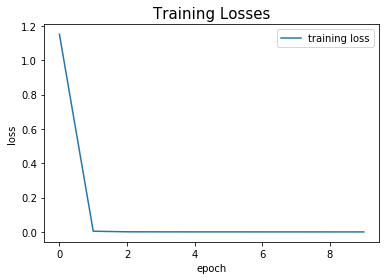

In [21]:
plt.plot(history.history['loss'])
plt.title('Training Losses',size = 15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss'], loc='upper right')
plt.show()

In [22]:
x_train_embedding = branch_model.predict(x_train)
x_test_embedding = branch_model.predict(x_test)

tsne = TSNE(n_components=2, random_state= 5)
train_tsne_embeds = tsne.fit_transform(x_train_embedding)
test_tsne_embeds = tsne.fit_transform(x_test_embedding)

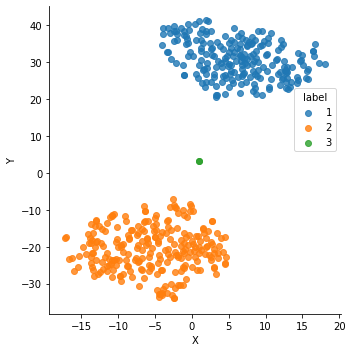

In [23]:
scatterDF =  pd.DataFrame(
    {'X': train_tsne_embeds[:,0],
     'Y': train_tsne_embeds[:,1],
     'Label': y_train
    })

scatter_plot = sns.lmplot(data=scatterDF, x='X', y='Y', hue='Label', fit_reg=False, legend=False)
legend = scatter_plot.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)

for i, text in enumerate(legend.get_texts()):
    plt.setp(text,color = 'black')


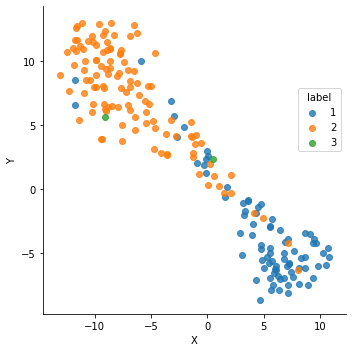

In [24]:
scatterDF =  pd.DataFrame(
    {'X': test_tsne_embeds[:,0],
     'Y': test_tsne_embeds[:,1],
     'Label': y_test
    })

scatter_plot = sns.lmplot(data=scatterDF, x='X', y='Y', hue='Label', fit_reg=False, legend=False)
legend = scatter_plot.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)

for i, text in enumerate(legend.get_texts()):
    plt.setp(text,color = 'black')

Build Multi-classification model

In [27]:
def dist_diff_square(a,b):
    return np.sum(np.square(a-b))

def pred(k_nearest_neighbors):
    pred_test = pd.DataFrame()
    pred_test['spectrogram_filename'] = [spectrogram_filename.split('Extracted_Mel_Spectrogram/')[-1] for spectrogram_filename in directory_filenames_test]
    pred_test['true_call_count'] = y_test
    pred_test['pred_call_count'] = None
    pred_test['pred_correct'] = 0
    for i in range(len(pred_test)):
        distance_with_each_category_name = []
        for category_name in category_name_list:
            category_name_train_index = [index for index, x in enumerate(y_train) if x == category_name]
            x_train_embedding_category_name = x_train_embedding[category_name_train_index]
            embedding_distance_category_name = [dist_diff_square(x_test_embedding[i], embedding) for embedding in x_train_embedding_category_name] 
            k_nearest_neighbors_category_name = sort(embedding_distance_category_name)[:k_nearest_neighbors]
            distance_with_each_category_name.append(mean(k_nearest_neighbors_category_name))
        most_similar_category_name_sorted = [category_name_list[i] for i in np.argsort(distance_with_each_category_name)]
        pred_test.at[i,'pred_call_count'] = most_similar_category_name_sorted[0]
        pred_test.at[i, 'pred_correct'] = int(y_test[i] in most_similar_category_name_sorted[0])
    return pred_test

In [28]:
pred_test = pred(k_nearest_neighbors = 10)
print('prediction accuracy for test set: ', "{0:.2%}".format(sum(pred_test.pred_correct) / len(pred_test)))

confusion_matrix = pd.crosstab(pred_test['true_call_count'], pred_test['pred_call_count'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

prediction accuracy for test set:  87.88%
Predicted   1    2
Actual            
1          72   10
2          12  102
3           1    1


In [18]:
x_train_embedding = branch_model.predict(x_train)
x_test_embedding = branch_model.predict(x_test)

(array([  1.,   5.,   3.,   6.,  19., 141.,   6.,   7.,   5.,   5.]),
 array([-1.37054634, -1.12128105, -0.87201576, -0.62275047, -0.37348518,
        -0.12421989,  0.12504539,  0.37431068,  0.62357597,  0.87284126,
         1.12210655]),
 <a list of 10 Patch objects>)

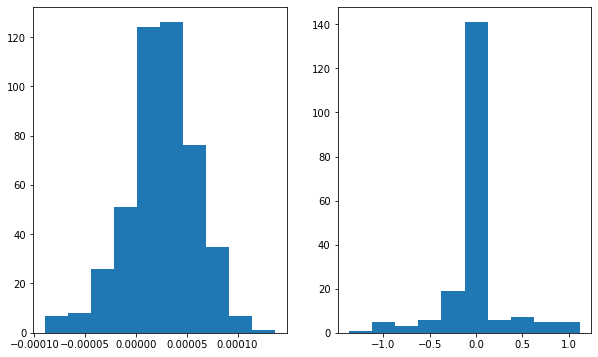

In [19]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train_embedding, y_train_original)

y_train_pred = reg.predict(x_train_embedding)
y_test_pred = reg.predict(x_test_embedding)
y_test_pred = np.array([max(0, y) for y in y_test_pred])

redidual_train = y_train_pred - y_train_original
redidual_test = y_test_pred - y_test_original

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axes[0].hist(redidual_train)
axes[1].hist(redidual_test)

In [20]:
print('Total number of calls in testing dataset: ', sum(y_test_original))
print('Total number of predicted calls in testing dataset: ', sum(y_test_pred))

Total number of calls in testing dataset:  316
Total number of predicted calls in testing dataset:  314.02875
